In [1]:
from fhd import *
import OpenEphys
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

In [3]:
fname_behavioral = '../data/behavioral/2019_08_12/random_corrective_saccades_160452.fhd'
fname_OE_x = '../data/OpenEphys_data/2019-08-12/2019-08-12_16-04-50/100_ADC2.continuous'
fname_OE_y = '../data/OpenEphys_data/2019-08-12/2019-08-12_16-04-50/100_ADC1.continuous'
messages_fname = '../data/OpenEphys_data/2019-08-12/2019-08-12_16-04-50/messages.events'

In [4]:
fhd_content = load(fname_behavioral)

target_x = np.squeeze(fhd_content['target_x'])
target_y = np.squeeze(fhd_content['target_y'])
eye_x = np.squeeze(fhd_content['right_horizontal_eye'])
eye_y = np.squeeze(fhd_content['right_vertical_eye'])
eye = np.linalg.norm(np.vstack((eye_x, eye_y)), axis = 0)
target = np.linalg.norm(np.vstack((target_x, target_y)), axis = 0)
el_t = np.squeeze(fhd_content['t'])
trials = fhd_content['trials']
# el_t = el_t - el_t[0]

In [7]:
el_t.size/(el_t[-1] - el_t[0])

1000.0005418356743

In [40]:
for k,v in zip(trials[4].keys(), trials[4].values()):
    print('{} : {}'.format(k,v))

# Loading state times from behavioral data
class trial_events:
    pass

trialevents = []
for trial in trials:
    trial_event = trial_events()
#     if not np.array_equal(trial['state_start_time_cue_target_present'], trial['state_start_time_detect_sac_start']):
#         print(trial['state_start_time_cue_target_present'], trial['state_start_time_detect_sac_start'])
    
    for k,v in zip(trial.keys(), trial.values()):
        exec('trial_event.' + k + '=v')
    trialevents.append(trial_event)

trial_start_time : [70.69882139]
target_width : [0.46606201]
target_height : [0.48378435]
start_x : [0.]
start_y : [0.]
cue_x : [-4.2426405]
cue_y : [4.2426405]
iss_x : [-5.5109107e-16]
iss_y : [-3.]
end_x : [-4.2426405]
end_y : [1.24264073]
fixation_time : [0.2]
punishment_time : [0.5]
iti : [0.2]
state_start_time_str_target_pursuit : [[70.69716]]
state_start_time_str_target_present : [[70.89828]]
state_start_time_str_target_fixation : [[70.89828]]
state_start_time_cue_target_present : [[71.43429]]
state_start_time_detect_sac_start : [[71.43429]]
state_start_time_saccade : [[71.63076]]
state_start_time_detect_sac_end : [[71.63076]]
state_start_time_deliver_reward : [[71.65623]]
state_start_time_end_target_fixation : [[71.82439]]
state_start_time_iti : [[72.02767]]
state_start_time_next_trial : [[72.23191]]
trial_end_time : [72.23720578]


In [37]:
trial['state_start_time_cue_target_present']

array([[1852.0902, 1856.1671, 1857.3137, 1858.8398, 1860.1368, 1862.228 ,
        1864.0281]], dtype=float32)

In [7]:
str_target_fixation_times = [te.state_start_time_str_target_fixation for te in trialevents if hasattr(te, 'state_start_time_str_target_fixation')]
str_target_fixation_times = np.squeeze(np.hstack(str_target_fixation_times))

target_presentation_time = [te.state_start_time_cue_target_present for te in trialevents if hasattr(te, 'state_start_time_cue_target_present')]
target_presentation_time = np.squeeze(np.hstack(target_presentation_time))

iti_times = [te.state_start_time_iti for te in trialevents if hasattr(te, 'state_start_time_iti')]
iti_times = np.squeeze(np.hstack(iti_times))

target_pursuit_start_times =  [te.state_start_time_str_target_pursuit for te in trialevents if hasattr(te, 'state_start_time_str_target_pursuit')]
target_pursuit_start_times = np.squeeze(np.hstack(target_pursuit_start_times))

detect_sac_end_times =  [te.state_start_time_detect_sac_end for te in trialevents if hasattr(te, 'state_start_time_detect_sac_end')]
detect_sac_end_times = np.squeeze(np.hstack(detect_sac_end_times))

In [9]:
detect_sac_end_times = detect_sac_end_times - el_t[0]
str_target_fixation_times = str_target_fixation_times - el_t[0]
target_presentation_time = target_presentation_time - el_t[0]
iti_times = iti_times - el_t[0]
target_pursuit_start_times = target_pursuit_start_times - el_t[0]
el_t = el_t - el_t[0]

In [10]:
# Loading network event data from Open Ephys data

with open(messages_fname, 'r') as f:
    file_content = f.readlines()
Fs = float(file_content[1].split('@')[-1][0:-3])
time0 = int(file_content[1].split(' ')[0])
net_events_prim = np.array([[l.split(' ')[0], l.split(' ')[1][1:]] for l in file_content if len(l.split(' ')) == 2 and 'P' in l.split(' ')[-1]]).astype(np.int)
net_events_corr = np.array([[l.split(' ')[0], l.split(' ')[1][1:]] for l in file_content if len(l.split(' ')) == 2 and 'C' in l.split(' ')[-1]]).astype(np.int)
net_events_prim[:,0] = net_events_prim[:,0] - time0
net_events_corr[:,0] = net_events_corr[:,0] - time0
directions_prim, counts_prim = np.unique(net_events_prim[:,1], return_counts=True)
directions_corr, counts_corr = np.unique(net_events_corr[:,1], return_counts=True)

In [11]:
# Loading eye position from Open Ephys data
file_content = OpenEphys.load(fname_OE_x)
Fs = float(file_content['header']['sampleRate'])
eye_OE_x = file_content['data']
file_content = OpenEphys.load(fname_OE_y)
eye_OE_y = file_content['data']
time_stamps = file_content['timestamps']
voltage_t = np.interp(np.arange(eye_OE_x.size), np.arange(0, eye_OE_x.size, eye_OE_x.size/time_stamps.size), time_stamps)

Loading continuous data...
Loading continuous data...


In [12]:
# Load DIO events from Open Ephys data
event_number = 3
events_file = '../data/OpenEphys_data/2019-08-12/2019-08-12_16-04-50/all_channels.events'
events_content = OpenEphys.load(events_file)
event_t = events_content['timestamps']
eventId = events_content['eventId']
channelId = events_content['channel']

sync_events = event_t[np.where(np.logical_and(channelId == event_number,eventId == 1))] # eventId = 1: rising edge, eventId = 0: falling edge
sync_events = sync_events - voltage_t[0]
voltage_t = voltage_t - voltage_t[0]
voltage_t = voltage_t/Fs
sync_events = sync_events/Fs

loading events...


In [13]:
time_diff = sync_events[0] - str_target_fixation_times[0]
print('DIO event time differeence = {}'.format(time_diff))
el_t_syncd_with_dio_event = el_t + time_diff

DIO event time differeence = 3.425713309733073


In [18]:
3.425713309733073 - 3.4121470906575517

0.013566219075521246

In [14]:
time_diff = net_events_corr[0,0]/Fs - detect_sac_end_times[0]
print('Network event time differeence = {}'.format(time_diff))
el_t_syncd_with_network_event = el_t + time_diff

Network event time differeence = 3.4121470906575517


In [15]:
from kaveh.toolbox import butter_bandpass_filter

eye_OE_x_filtered = butter_bandpass_filter(eye_OE_x, 0.01, 600, Fs, order=2 )
eye_OE_y_filtered = butter_bandpass_filter(eye_OE_y, 0.01, 600, Fs, order=2 )


<IPython.core.display.Javascript object>


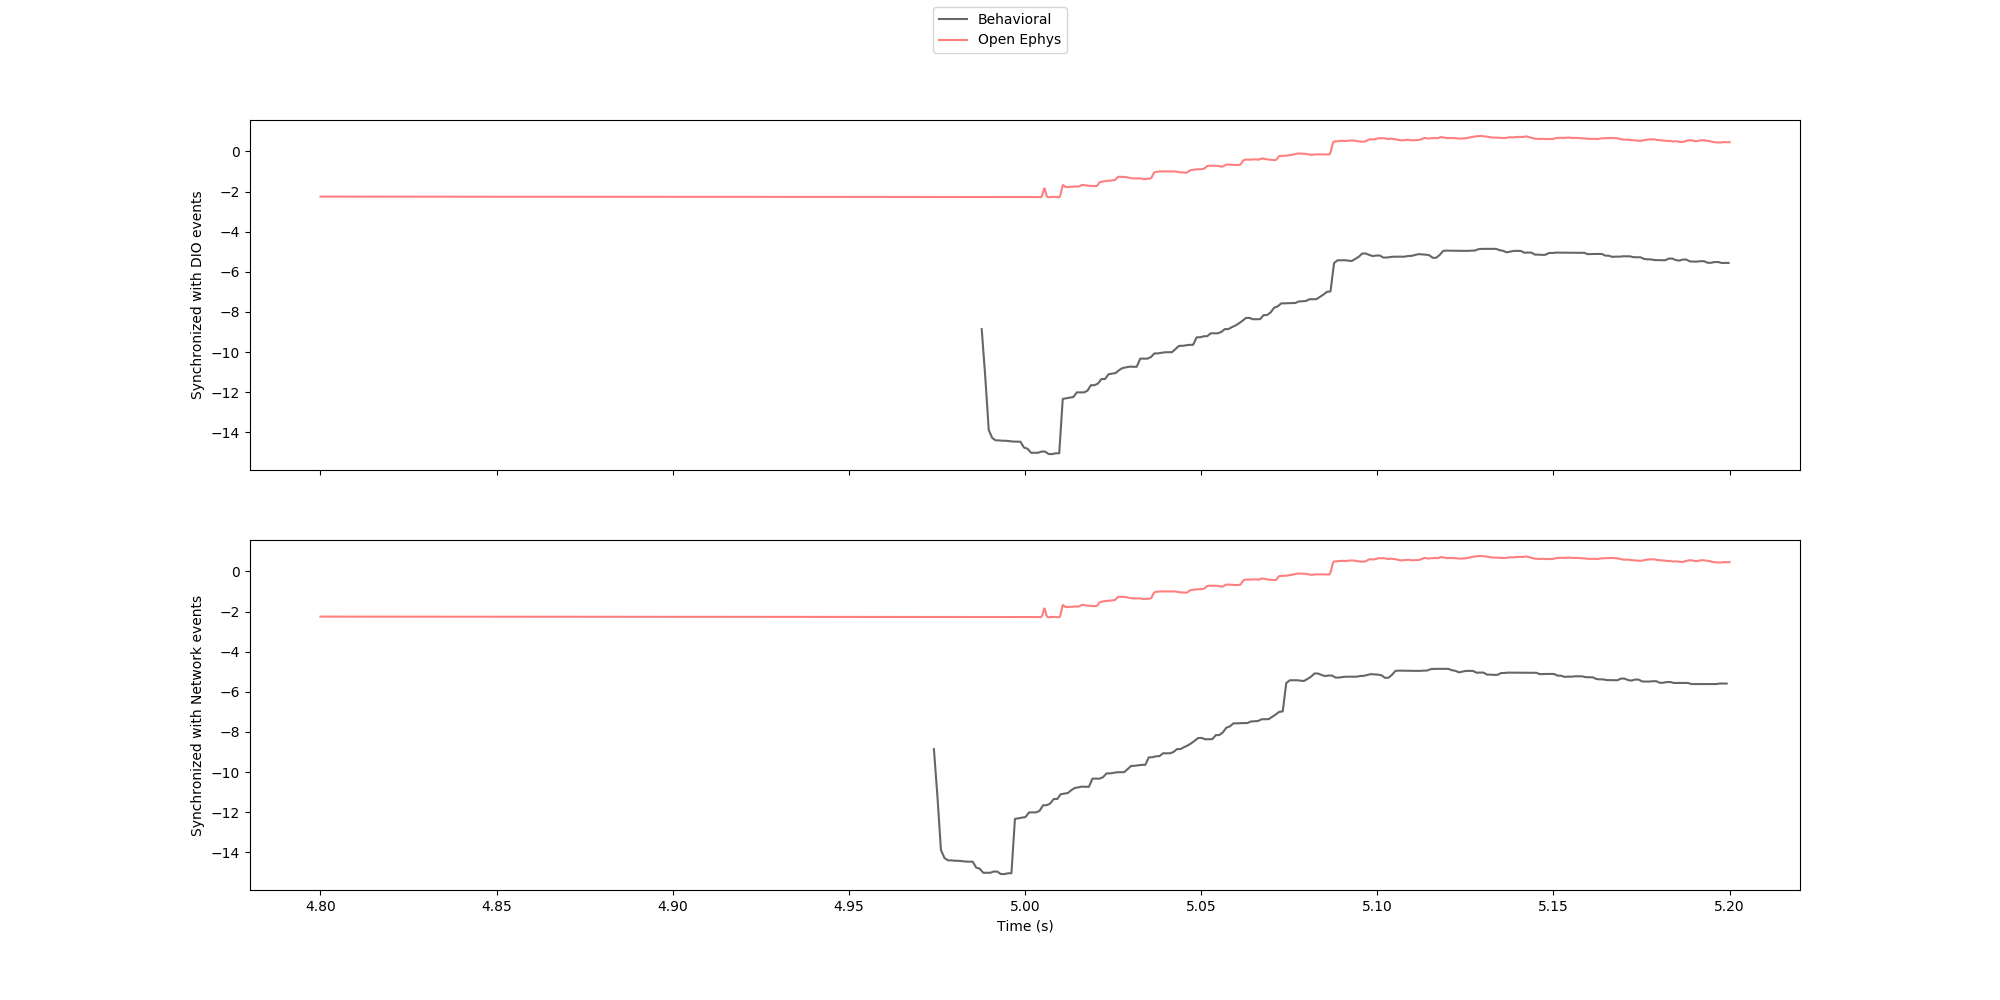

In [33]:
f, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1,1]}, figsize=(20,10), sharex=True, sharey=True)
t_range = [4.8, 5.2]


ax0_l1 = ax0.plot(el_t_syncd_with_dio_event[np.where(np.logical_and(el_t_syncd_with_dio_event < t_range[1], el_t_syncd_with_dio_event > t_range[0]))],
                  eye_x[np.where(np.logical_and(el_t_syncd_with_dio_event < t_range[1], el_t_syncd_with_dio_event > t_range[0]))] ,color='k', alpha=0.6)
ax0_l2 = ax0.plot(voltage_t[np.where(np.logical_and(voltage_t < t_range[1], voltage_t > t_range[0]))], eye_OE_x_filtered[np.where(np.logical_and(voltage_t < t_range[1], voltage_t > t_range[0]))], color='r', alpha=0.5)
# ax0.eventplot(str_target_fixation_times, linelengths=10 , zorder=10, colors='g', alpha=0.3)
# ax0.eventplot(iti_times, linelengths=10 , zorder=10, colors='r', alpha=0.3)
# ax0.eventplot(net_events_prim[:,0]/Fs, linelengths=10 , lineoffsets=-10,zorder=10, colors='m', alpha=0.3)
# ax0.eventplot(sync_events, linelengths=10 , lineoffsets=-10,zorder=10, colors='m', alpha=0.3)

# ax0_l2 = ax0.plot(el_t, target_x , '--',color='y', alpha=1)
ax0.set_ylabel('Synchronized with DIO events')
ax1.plot(el_t_syncd_with_network_event[np.where(np.logical_and(el_t_syncd_with_network_event < t_range[1], el_t_syncd_with_network_event > t_range[0]))],
                  eye_x[np.where(np.logical_and(el_t_syncd_with_network_event < t_range[1], el_t_syncd_with_network_event > t_range[0]))] ,color='k', alpha=0.6)
ax1.plot(voltage_t[np.where(np.logical_and(voltage_t < t_range[1], voltage_t > t_range[0]))], eye_OE_x_filtered[np.where(np.logical_and(voltage_t < t_range[1], voltage_t > t_range[0]))], color='r', alpha=0.5)
# ax1.plot(el_t, eye_y ,color='k', alpha=0.6)
# ax1.plot(el_t, target_y , '--',color='m', alpha=0.6)
ax1.set_ylabel('Synchronized with Network events')
ax1.set_xlabel('Time (s)')
# ax2.plot(el_t, eye ,color='k', alpha=0.6)
# ax2.plot(el_t, target , '--',color='m', alpha=0.6)
# ax2.set_ylabel('Magnitude')
# plt.eventplot(events_pursuit, linelengths=10 , zorder=10, colors='r', alpha=0.3)

# ax2.plot(voltage_t, eye_OE_x_filtered, color='k', alpha=0.6)
f.legend((ax0_l1[0], ax0_l2[0]), ('Behavioral' , 'Open Ephys'), 'upper center')


In [34]:
plt.savefig('../data/plots/for_weekly/OE_vs_EL_eye_network_dio_sync_zoomed_in.png')